一般的に待機児童問題と呼ばれる問題がある。実際の待機児童のデータの様子の可視化を試みる。

In [1]:
import glob
import pandas as pd
import geopandas as gpd
import re
from matplotlib import pyplot as plt

In [2]:
%matplotlib inline
import matplotlib
jafont=matplotlib.font_manager.FontProperties(fname="ipaexg.ttf")
ja = dict(fontproperties=jafont)

幼稚園と保育園を弾力的に運用できるようにするために「こども園」という仕組みが導入された。この新制度の運用状況は[神戸市のページ](http://www.city.kobe.lg.jp/child/grow/shinseido/index02_03.html)でデータが公開されている。

幼稚園・保育園・こども園のデータを統合して `geojson` の形式にできるようにしたので、それを使う。読み込むデータはとりあえず最新版の 2016-09-15 時点のものを使ってみた。

In [3]:
nib = gpd.read_file("../data/hkwi/shinseido-2016-09.json")

# nib のセルのいくつかは数値に補足情報が付いているので、除去する
def drop_notes(c):
    if c is not None and len(c):
        m = re.match(r'^(\d+)\s*[（\()]内地域枠\d+[）\)]$', c)
        if m:
            return int(m.group(1))
        elif c[-1] in "*＊":
            return int(c[:-1])
        else:
            return int(c)
    return None

#"状況,利用定員（２・３号）"は本園に合算されているので使わない
k1 = ["状況,合計", "１号,認可定員(全体)", "２号３号,利用定員（2・3号）"]
k2 = ["状況,申込児童数 %s歳児" % "０１２３４５"[i] for i in range(6)]
k3 = ["%d歳" % i for i in range(6)]
for k in k1+k2:
    nib[k] = nib[k].apply(drop_notes)

## 神戸市全域

まずは市全域を合算してプロットしてみる。0歳児から5歳児に向かって、単調に減少する形をしていることが読み取れる。

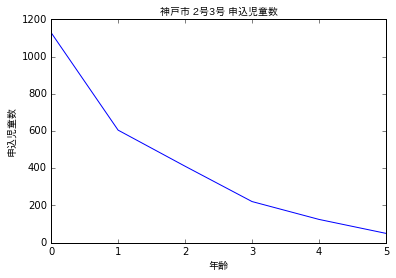

In [4]:
plt.plot(nib.sum()[k2].values)
plt.title("神戸市 2号3号 申込児童数", **ja)
plt.xlabel("年齢", **ja)
plt.ylabel("申込児童数", **ja)

参考までに年齢ごとの人口をプロットしてみる。人口のデータは神戸市の[年齢別の人口データ](http://www.city.kobe.lg.jp/information/data/statistics/toukei/jinkou/juukijinkou.html)（オープンデータ）を使う。2016-09-15 時点のデータは存在しないので、2016-08 末時点のデータで代用する。

In [5]:
def load_zensi(fname):
    e = pd.ExcelFile(fname)
    opts = dict(skiprows=1, converters={"区コード":str, "町コード":str})
    dfs = [e.parse(s, **opts).iloc[1:,:] for s in e.sheet_names if s != "神戸市"]
    return gpd.GeoDataFrame(pd.concat(dfs, ignore_index=True))

zib = load_zensi("../data/kobe/zensi2808.xls")

プロットする。0歳のほうが少ない。

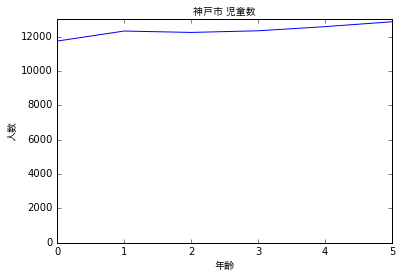

In [6]:
plt.plot(zib.sum()[k3].T.values)
plt.ylim(ymin=0)
plt.title("神戸市 児童数", **ja)
plt.xlabel("年齢", **ja)
plt.ylabel("人数", **ja)

単位児童あたりの申込数をプロットする。やっぱり0歳から5歳に向かって減っていく傾向にある。

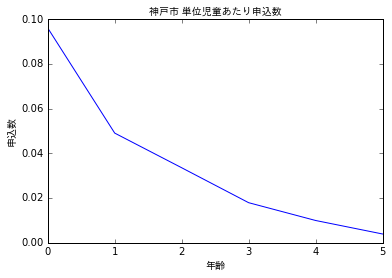

In [7]:
r0 = nib.sum().rename(index=dict(zip(k2,k3)))/zib.sum()
plt.plot(r0[k3].T.values)
plt.title("神戸市 単位児童あたり申込数", **ja)
plt.xlabel("年齢", **ja)
plt.ylabel("申込数", **ja)

## 地区レベル

地区ごとに集計してプロットしてみる。大まかに全体としても 0 歳から 5 歳に向かって減る形をしている。

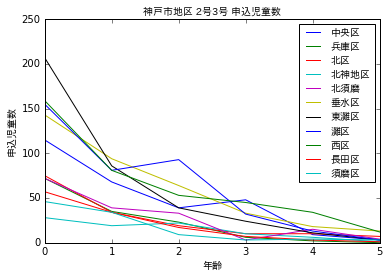

In [8]:
d0 = nib.groupby("状況,地区").sum()
plt.plot(d0[k2].T.values)
plt.title("神戸市地区 2号3号 申込児童数", **ja)
plt.xlabel("年齢", **ja)
plt.ylabel("申込児童数", **ja)
plt.legend(d0.index, prop=jafont)

地区レベルでの児童数はこのようになっている。

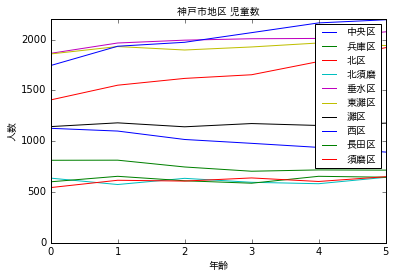

In [9]:
d1 = zib.groupby("区・支所").sum().rename(index={"北須磨支所":"北須磨"})
plt.plot(d1[k3].T.values)
plt.ylim(ymin=0)
plt.title("神戸市地区 児童数", **ja)
plt.xlabel("年齢", **ja)
plt.ylabel("人数", **ja)
plt.legend(d1.index, prop=jafont)

単位児童当たりの申込数をプロットする。人口データと申込児童数データの地域区分を揃えてから計算する。

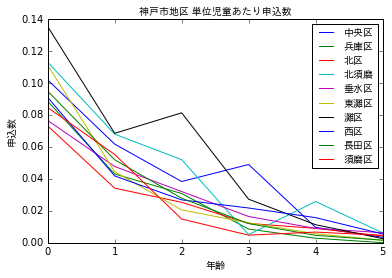

In [10]:
nib2 = nib.groupby("状況,地区").sum()
nib2.loc["北区",:] += nib2.loc["北神地区",:]
nib3 = nib2.loc[[i for i in nib2.index if i!="北神地区"],:].rename(columns=dict(zip(k2,k3)))
d2 = (nib3/d1)[k3]
plt.plot(d2.T.values)
plt.title("神戸市地区 単位児童あたり申込数", **ja)
plt.xlabel("年齢", **ja)
plt.ylabel("申込数", **ja)
plt.legend(d2.index, prop=jafont)

## 倍率

地区ごとに全体と比べて、どのぐらい倍率が違うのかを表示する。倍率で見ると、0 歳のほうが地域ごとのばらつきは小さく、地域ごと年齢ごとの状況は年齢が上がるほうが大きくなる。

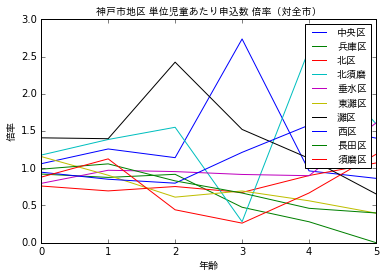

In [11]:
r1 = d2/r0
plt.plot(r1[k3].T.values)
plt.title("神戸市地区 単位児童あたり申込数 倍率（対全市）", **ja)
plt.xlabel("年齢", **ja)
plt.ylabel("倍率", **ja)
plt.legend(r1.index, prop=jafont)